
Разработать программу, распознающую по фото не менее 5 эмоций человека на выбор с использованием дообучения.

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/emotions.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: MMAFEDB/valid/neutral/8867Exp6fighting_expression_295.jpg  
  inflating: MMAFEDB/valid/neutral/8870Exp6fighting_expression_308.jpg  
  inflating: MMAFEDB/valid/surprise/Surprise.32243.jpg  
  inflating: MMAFEDB/valid/surprise/Surprise.32265.jpg  
  inflating: MMAFEDB/valid/surprise/Surprise.32266.jpg  
  inflating: MMAFEDB/valid/surprise/Surprise.32283.jpg  
  inflating: MMAFEDB/valid/surprise/Surprise.32284.jpg  


In [ ]:
train_dir = "/content/MMAFEDB/train" 
test_dir = "/content/MMAFEDB/test"  

In [ ]:
img_size = 48

In [ ]:
train_datagen = ImageDataGenerator(
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 74378 images belonging to 7 classes.
Found 3469 images belonging to 7 classes.


In [ ]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
epochs = 20
batch_size = 32

In [ ]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/20
1163/1163 [==============================] - 61s 52ms/step - loss: 7.5439 - accuracy: 0.3209 - val_loss: 5.4868 - val_accuracy: 0.3722
Epoch 19/20
1163/1163 [==============================] - 58s 50ms/step - loss: 1.2437 - accuracy: 0.6616 - val_loss: 1.6331 - val_accuracy: 0.5267
Epoch 20/20
1163/1163 [==============================] - 58s 50ms/step - loss: 1.2301 - accuracy: 0.6666 - val_loss: 1.7169 - val_accuracy: 0.5036


In [ ]:
model.save('model_optimal.h5')

(48, 48)


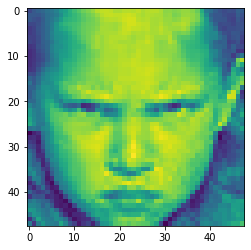

In [ ]:
img = image.load_img("/content/MMAFEDB/test/angry/1455Exp0angry_girl_299.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) 


In [ ]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [ ]:
img = np.expand_dims(img,axis = 0) 
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)


[0.99121124, 0.008788741, 0.0, 0.0, 5.5490513e-29, 9.457617e-33, 0.0]


In [ ]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()


Angry


In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))


55/55 [==============================] - 1s 21ms/step - loss: 1.7169 - accuracy: 0.5036
final train accuracy = 68.78 , validation accuracy = 50.36


In [ ]:
model.save_weights('model_weights.h5')